In [42]:
#importing the required packages
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy,AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from tensorflow.keras.optimizers import Adam
import itertools
import cv2
import scipy.integrate as integrate
import scipy
from tensorflow.keras.applications import VGG16,VGG19,ResNet50,ResNet101, ResNet152,InceptionResNetV2,inception_v3

## Importing Images

In [52]:
data_dir = "D:\AI_Projects\TB\Dataset"
categories = ["Normal", "Tuberculosis"]

In [53]:
#resizing images
img_size = (256, 256)  
data = []

In [54]:
for category_id, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, img_size)
        data.append([img_array, category_id])

data = shuffle(data)

In [74]:
X = np.array([x[0] for x in data]).reshape(-1, img_size[0], img_size[1], 1)
y = np.array([x[1] for x in data])

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

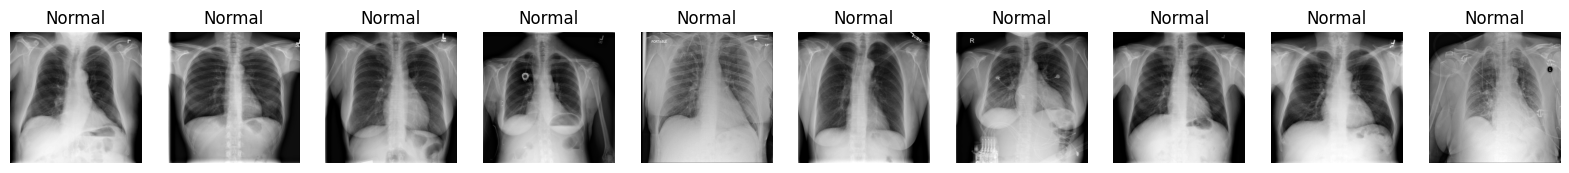

In [56]:
def plot_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(img_size), cmap='gray')
        axes[i].set_title(categories[labels[i]])
        axes[i].axis('off')
    plt.show()
    
plot_images(X_train, y_train)

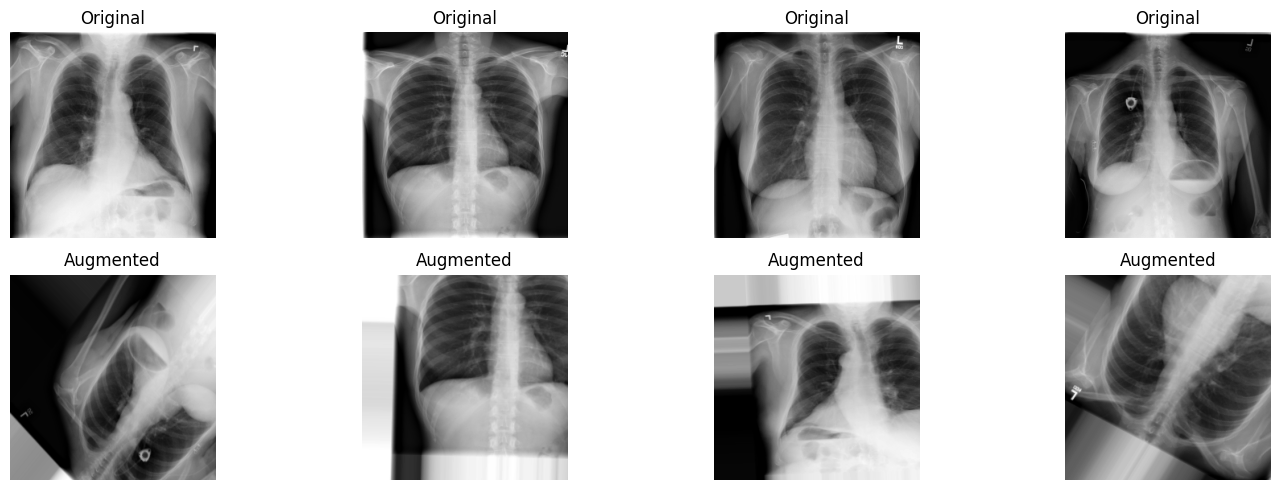

In [57]:
datagen = ImageDataGenerator(
    rotation_range=60,  # Random rotation in the range of 0-60 degrees
    width_shift_range=0.2,  # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=True,  # Random vertical flipping
    fill_mode='nearest'  
)

datagen.fit(X_train)

def plot_original_and_augmented(original_images, augmented_images, labels, num_images=4):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        axes[0, i].imshow(original_images[i].reshape(img_size), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(augmented_images[i].reshape(img_size), cmap='gray')
        axes[1, i].set_title("Augmented")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


batch_size = 4  
num_augmented = 2  

augmented_generator = datagen.flow(X_train[:batch_size], y_train[:batch_size], batch_size=batch_size)

augmented_images, _ = next(augmented_generator)

plot_original_and_augmented(X_train[:batch_size], augmented_images, [y_train[0]] * batch_size)



In [58]:
num_train_samples = X_train.shape[0]
num_val_samples = X_val.shape[0]
num_test_samples = X_test.shape[0]

print("Number of samples in training set:", num_train_samples)
print("Number of samples in validation set:", num_val_samples)
print("Number of samples in testing set:", num_test_samples)

num_normal_samples = np.sum(y_train == 0) + np.sum(y_val == 0) + np.sum(y_test == 0)
num_infected_samples = np.sum(y_train == 1) + np.sum(y_val == 1) + np.sum(y_test == 1)

print("Number of TB_normal samples:", num_normal_samples)
print("Number of TB_infected samples:", num_infected_samples)


Number of samples in training set: 2688
Number of samples in validation set: 672
Number of samples in testing set: 840
Number of TB_normal samples: 3500
Number of TB_infected samples: 700


In [59]:
def count_samples_per_class(y):
    num_classes = np.max(y) + 1
    class_counts = np.zeros(num_classes, dtype=int)
    for i in range(num_classes):
        class_counts[i] = np.sum(y == i)
    return class_counts

train_class_counts = count_samples_per_class(y_train)
print("Number of samples per class in training set:")
for i, count in enumerate(train_class_counts):
    print(f"Class {i}: {count}")

val_class_counts = count_samples_per_class(y_val)
print("\nNumber of samples per class in validation set:")
for i, count in enumerate(val_class_counts):
    print(f"Class {i}: {count}")

test_class_counts = count_samples_per_class(y_test)
print("\nNumber of samples per class in testing set:")
for i, count in enumerate(test_class_counts):
    print(f"Class {i}: {count}")

Number of samples per class in training set:
Class 0: 2233
Class 1: 455

Number of samples per class in validation set:
Class 0: 562
Class 1: 110

Number of samples per class in testing set:
Class 0: 705
Class 1: 135


In [60]:
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

num_images_to_augment_class_0 = int(0.05 * len(class_0_indices)) 
num_images_to_augment_class_1 = int(0.3 * len(class_1_indices)) 

indices_to_augment_class_0 = np.random.choice(class_0_indices, num_images_to_augment_class_0, replace=False)
indices_to_augment_class_1 = np.random.choice(class_1_indices, num_images_to_augment_class_1, replace=False)

augmented_train_data = []
augmented_train_labels = []

for i in indices_to_augment_class_0:
    sample = X_train[i].reshape((1,) + X_train[i].shape)  
    augmented_samples = datagen.flow(sample, batch_size=1)
    for batch in augmented_samples:
        augmented_train_data.append(batch[0])
        augmented_train_labels.append(y_train[i])
        break

for i in indices_to_augment_class_1:
    sample = X_train[i].reshape((1,) + X_train[i].shape)  
    augmented_samples = datagen.flow(sample, batch_size=1)
    for batch in augmented_samples:
        augmented_train_data.append(batch[0])
        augmented_train_labels.append(y_train[i])
        break

augmented_train_data = np.array(augmented_train_data)
augmented_train_labels = np.array(augmented_train_labels)

X_train_augmented = np.concatenate((X_train, augmented_train_data))
y_train_augmented = np.concatenate((y_train, augmented_train_labels))

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)

augmented_train_class_counts = count_samples_per_class(y_train_augmented)
print("Number of samples per class in augmented training set:")
for i, count in enumerate(augmented_train_class_counts):
    print(f"Class {i}: {count}")

Number of samples per class in augmented training set:
Class 0: 2344
Class 1: 591


In [61]:
X_train_rgb = np.repeat(X_train_augmented[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

X_train_rgb = np.squeeze(X_train_rgb, axis=-2)
X_val_rgb = np.squeeze(X_val_rgb, axis=-2)
X_test_rgb = np.squeeze(X_test_rgb, axis=-2)

## VGG 16

In [66]:
# Load pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze pre-trained layers in VGG16
for layer in vgg16.layers:
    layer.trainable = False

# Create new model with VGG16 as base
model = Sequential()
model.add(vgg16)

# Add custom layers for classification
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [63]:
y_train_augmented = to_categorical(y_train_augmented)
y_val = to_categorical(y_val)
#y_test = to_categorical(y_test)

In [65]:
print(X_train_rgb.shape, y_train_augmented.shape)

(2935, 256, 256, 3) (2935, 2)


In [67]:
#training
history = model.fit(X_train_rgb, y_train_augmented, epochs=10, batch_size=32, validation_data=(X_val_rgb, y_val))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8662 - loss: 0.6776 - val_accuracy: 0.9911 - val_loss: 0.0313
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.9748 - loss: 0.0664 - val_accuracy: 0.9911 - val_loss: 0.0273
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9953 - loss: 0.0231 - val_accuracy: 0.9911 - val_loss: 0.0247
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9914 - loss: 0.0278 - val_accuracy: 0.9777 - val_loss: 0.0530
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9890 - loss: 0.0301 - val_accuracy: 0.9955 - val_loss: 0.0144
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.9991 - loss: 0.0094 - val_accuracy: 0.9955 - val_loss: 0.0111
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9955 - val_loss: 0.0150
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9970 - v

27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step


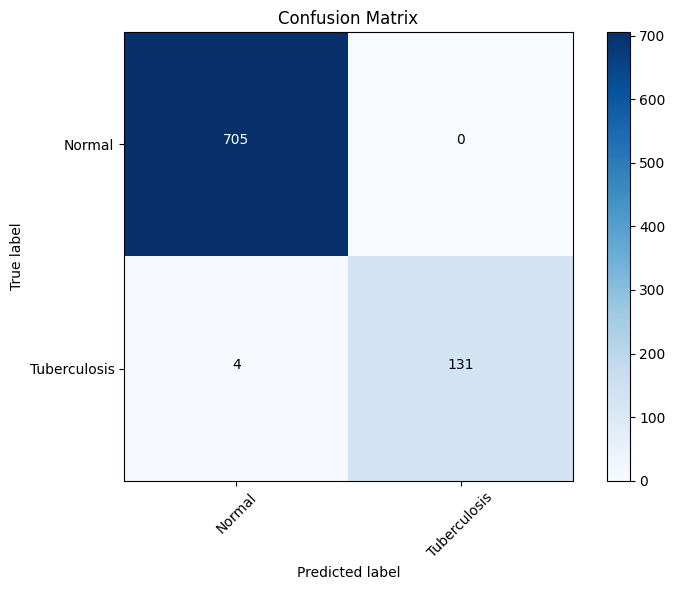

In [76]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()